# Cumprimento das atividades do segundo notebook conforme tasks/CP1.txt

Faremos novamente a clusterização com k=5, utilizando as features de ano e gênero.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.sparse import hstack, csr_matrix
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\José\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# Processamentos comuns ao notebook anterior
df = pd.read_csv("data/imdb_top250.csv")
df["genre"] = df["genre"].str.split(",").str[0].str.strip()
df['sinopse'] = df['sinopse'].str.lower()
df['sinopse'].head()
stopwords = nltk.corpus.stopwords.words('portuguese')
df['sinopse_no_stopwords'] = df['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

## Obtendo X

TF-IDF das sinopses sem stopwords

In [33]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=0.05, max_df=0.95, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['sinopse_no_stopwords'])

One-hot dos gêneros, em que cada coluna indica se o filme pertence a um determinado gênero

In [34]:
genre_cols = ['genre'] 
df_processed = pd.get_dummies(df, columns=genre_cols)
X_genre = df_processed[[col for col in df_processed.columns if col.startswith('genre_')]].values


One-hot da binagem dos anos, que agrupa os filmes em intervalos de anos, transformando em variáveis categóricas

In [35]:
bins = [1920, 1950, 1970, 1980, 1990, 2000, 2010, 2020, 2025]
labels = [0,1,2,3,4,5,6,7]

df_processed['year_bin'] = pd.cut(df_processed['year'], bins=bins, labels=labels, right=False)

df_processed = pd.get_dummies(df_processed, columns=['year_bin'])
year_cols = [col for col in df_processed.columns if col.startswith('year_bin_')]
X_year = df_processed[year_cols].values


Transformando arrays densos em sparse matrices para concatenar eficientemente

In [ ]:

X_genre_sparse = csr_matrix(X_genre)
X_year_sparse = csr_matrix(X_year)

# Combinação de todas as features em uma única matriz de entrada para KMeans
X_full = hstack([X_tfidf, X_genre_sparse, X_year_sparse])


# Fit do Kmeans com k=5

In [37]:
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_full)

df['cluster'] = labels
df

,title,year,rating,genre,sinopse,sinopse_no_stopwords,cluster
0,Um Sonho de Liberdade,1994,9.3,Drama,dois homens presos se reúnem ao longo de vário...,"dois homens presos reúnem longo vários anos, e...",3
1,O Poderoso Chefão,1972,9.2,Policial,o patriarca idoso de uma dinastia do crime org...,patriarca idoso dinastia crime organizado tran...,4
2,Batman: O Cavaleiro das Trevas,2008,9.1,Ação,agora com a ajuda do tenente jim gordon e do p...,agora ajuda tenente jim gordon promotor públic...,2
3,O Poderoso Chefão: Parte II,1974,9.0,Policial,o início da vida e da carreira de vito corleon...,início vida carreira vito corleone década 1920...,4
4,12 Homens e uma Sentença,1957,9.0,Policial,o julgamento de um assassinato em nova iorque ...,julgamento assassinato nova iorque frustrado ú...,4
...,...,...,...,...,...,...,...
245,Gangues de Wasseypur,2012,8.2,Ação,um confronto entre sultão e shahid khan leva à...,confronto sultão shahid khan leva expulsão kha...,0
246,Na Natureza Selvagem,2007,8.0,Aventura,"depois de terminar a universidade, christopher...","terminar universidade, christopher mccandless ...",3
247,Histórias Cruzadas,2011,8.1,Drama,uma aspirante a escritora durante o movimento ...,aspirante escritora durante movimento direitos...,0
248,Troca Surpresa,2023,8.3,Comédia,trocadas por acidente enquanto viajavam até a ...,trocadas acidente enquanto viajavam casa novos...,1


## Filmes por cluster

In [38]:
fig = px.bar(df.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

## % de Gêneros por Cluster

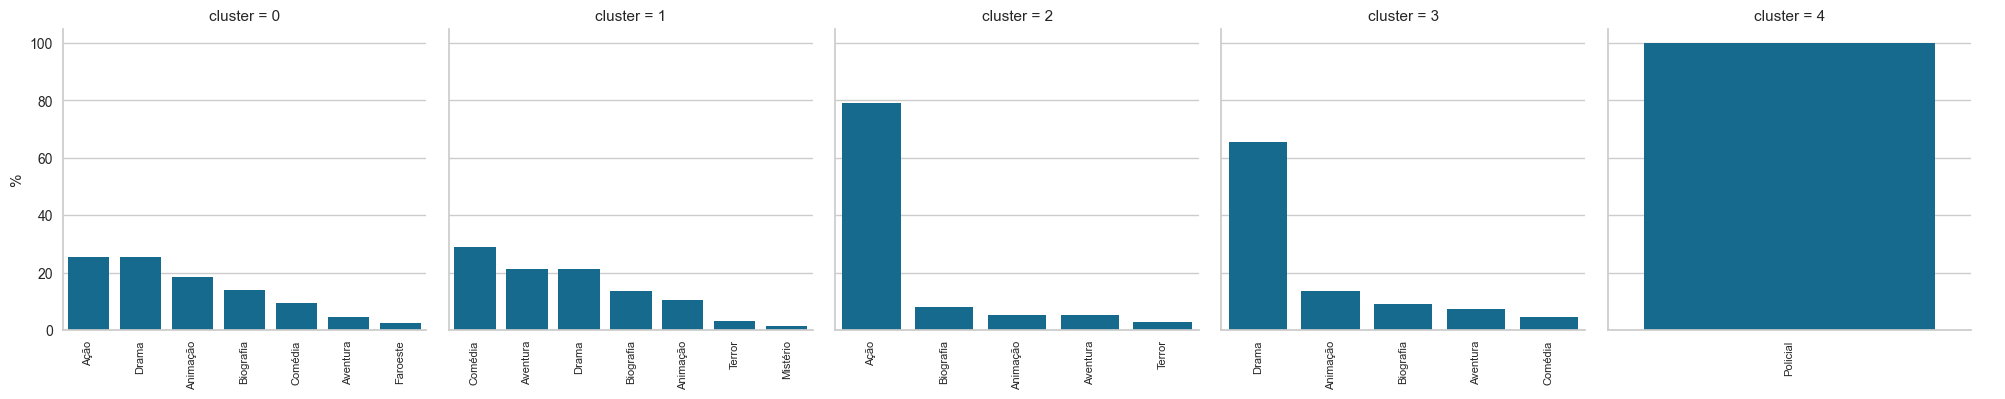

In [39]:
df_plot = df.groupby(['cluster', 'genre'])['title'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

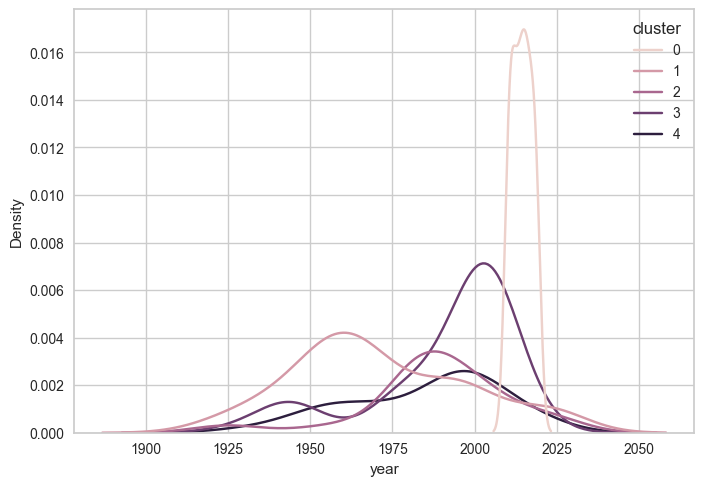

In [40]:
sns.kdeplot(df, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [ ]:

df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'genre', columns = 'cluster', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

genre,cluster,Animação,Aventura,Ação,Biografia,Comédia,Drama,Faroeste,Mistério,Policial,Terror
0,0,18.604651,4.651163,25.581395,13.953488,9.302326,25.581395,2.325581,0.000000,0.0,0.000000
1,1,10.606061,21.212121,0.000000,13.636364,28.787879,21.212121,0.000000,1.515152,0.0,3.030303
2,2,5.263158,5.263158,78.947368,7.894737,0.000000,0.000000,0.000000,0.000000,0.0,2.631579
3,3,13.432836,7.462687,0.000000,8.955224,4.477612,65.671642,0.000000,0.000000,0.0,0.000000
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.0,0.000000


# Nuvem de Palavras por Cluster

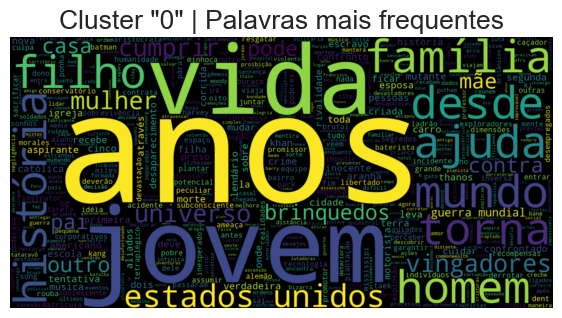

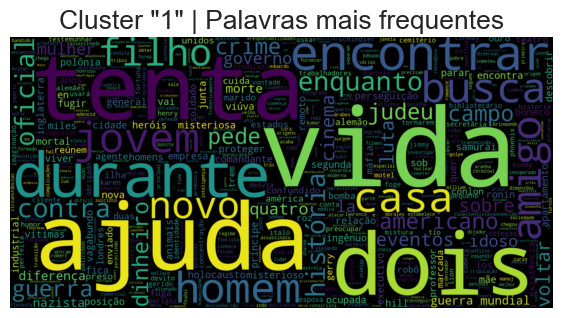

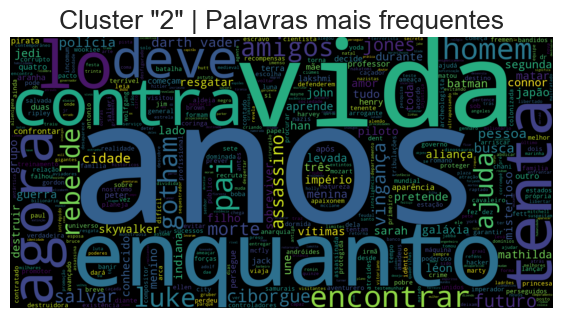

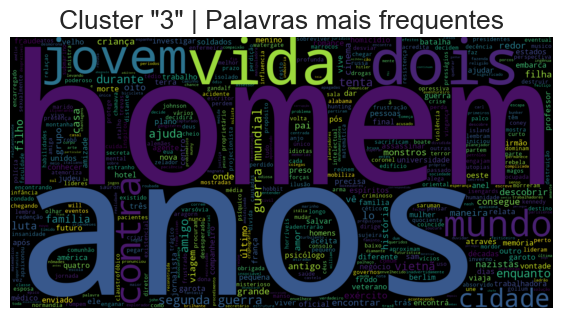

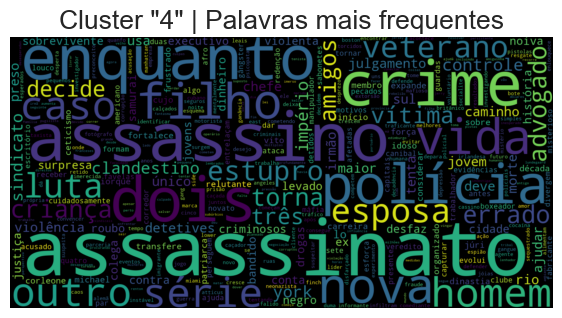

In [42]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df.loc[df.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

for c in range(5):
  word_cloud_cluster(c)

# Comparação do novo modelo com features de gênero e ano com o anterior

## 1) Balanceamento

Houve uma melhoria expressiva no balanceamento com a escolha de k=5. O novo agrupamento apresenta um tamanho máximo de 67 amostras (cluster 3) e mínimo de 36 amostras (cluster 4). Isso significa uma razão entre maior e menor muito inferior ao desbalanceamento extremo anterior. Ou seja, a nova configuração reduz fortemente o viés de “absorção” de quase todas as amostras por um único centro — um efeito que, antes, indicava problema de granularidade ou de features.

## 2) Distribuição dos gêneros

Cluster 0
Presença equilibrada de Ação (25,5%) e Drama (25,5%), seguidos por Animação (18,6%) e Biografia (14%). Trata-se de um perfil híbrido, combinando dinamismo, carga dramática e títulos voltados ao público jovem.

Cluster 1
Predomínio de Comédia (28,8%), acompanhado por Aventura (21,2%) e Drama (21,2%). O conjunto remete a narrativas mais leves, de entretenimento diversificado, com algum teor biográfico (13,6%).

Cluster 2
Ação domina de forma quase absoluta (78,9%), seguida apenas por pequenas ocorrências de Biografia (7,9%) e Aventura/Animação (5,3%). É um cluster mais puro, caracterizando-se claramente como núcleo de filmes de ação.

Cluster 3
Drama concentra 65,7% das ocorrências, complementado por Animação (13,4%) e Biografia (9%). É um agrupamento de forte caráter dramático, muitas vezes associado a contextos de guerra e narrativas intensas.

Cluster 4
Exclusivamente Policial (100%). Configura um cluster altamente coeso e especializado em tramas criminais.

Em comparação com o modelo anterior, que apresentava sobreposição generalizada de gêneros — sobretudo com o Drama sempre em posição central —, a nova clusterização revela divisões muito mais nítidas. Há agora clusters com alta pureza de gênero (2, 3 e 4) e outros que funcionam como mistos coerentes (0 e 1). Isso representa um ganho expressivo na interpretabilidade.

## 3) Distribuição temporal

Pela análise do gráfico de densidade, o Cluster 0 mostra exclusividade por filmes a partir dos anos 2000. Cluster 3 concentra filmes mais recentes (também tendência para títulos contemporâneos). Cluster 1 tende a agrupar filmes mais antigos. Isso indica que,ao contrário do cenário anterior, em que não se observavam diferenças temporais relevantes entre os clusters, o novo modelo revela separação temporal significativa em pelo menos três clusters.

## 4) Nuvens de palavras

Cluster 0
Termos como anos, jovem, vida, ajuda, torna, desde, guerra aparecem com relativa frequência. 
A mistura de referências temporais (anos, desde), pessoais (jovem, vida) e históricas (guerra) sugere um vocabulário heterogêneo, sem uma identidade semântica forte.

Cluster 1
Palavras como vida, ajuda, tenta, dois, durante, guerra, encontrar reiteram o mesmo campo de interações interpessoais e de conflito. 
O vocabulário é bastante próximo ao do cluster 0, o que dificulta a distinção entre eles em termos de sinopse.

Cluster 2
Destacam-se enquanto, contra, tenta, vida, agora, deve, encontrar. O predomínio de conectores e verbos de ação reflete antes estruturas narrativas genéricas do que marcadores temáticos claros, o que reforça a percepção de sobreposição com os demais.

Cluster 3
Aparecem guerra, homem, dois, contra, vida, segunda, jovem. A recorrência de guerra em alta frequência poderia sugerir uma concentração temática em narrativas bélicas; mas não se há de esquecer que o mesmo termo também apareceu em outros clusters.

Cluster 4
Palavras como assassinato, assassino, caso, homem introduzem claro viés criminal, o que provavelmente foi capturado a partir da segregação do gênero criminal em um único cluster.

Em suma, diferentemente do modelo anterior — em que as nuvens de palavras reforçavam distinções temáticas ligadas a drama, guerra, cotidiano ou crime —, o novo modelo apresenta vocabulário muito mais homogêneo entre os clusters, salvo para o cluster 4. Isso sugere que, ao integrar novas features, perdeu-se parte da sensibilidade para diferenciar o conteúdo narrativo das sinopses, resultando em agrupamentos cuja separação se apoia mais em dimensões estruturais (como gênero e temporalidade) do que em nuances textuais.

# Conclusão

O novo modelo, ao integrar gênero e ano, supera o anterior em termos de balanceamento, pureza dos agrupamentos e distinção temporal, o que amplia sua utilidade prática para análises estruturais. Embora o modelo anterior retenha maior sensibilidade semântica nas sinopses, seu desbalanceamento compromete a consistência dos resultados. Assim, como regra geral, o novo modelo deve ser considerado a melhor escolha, ficando o anterior restrito a contextos em que a captura de nuances narrativas seja prioridade absoluta.